# Counting Boxes using images captured from a drone flying overhead.

**Overview**:

In the current image, there are 7 "fully visible" staging areas, which I named A to G. The total number of visible top boxes in each staging area are 4, 52, 42, 52, 33, 68, 31 from A-G respectively. Two approaches using computer vision that can help with estimating the number of boxes in the current image are described below.

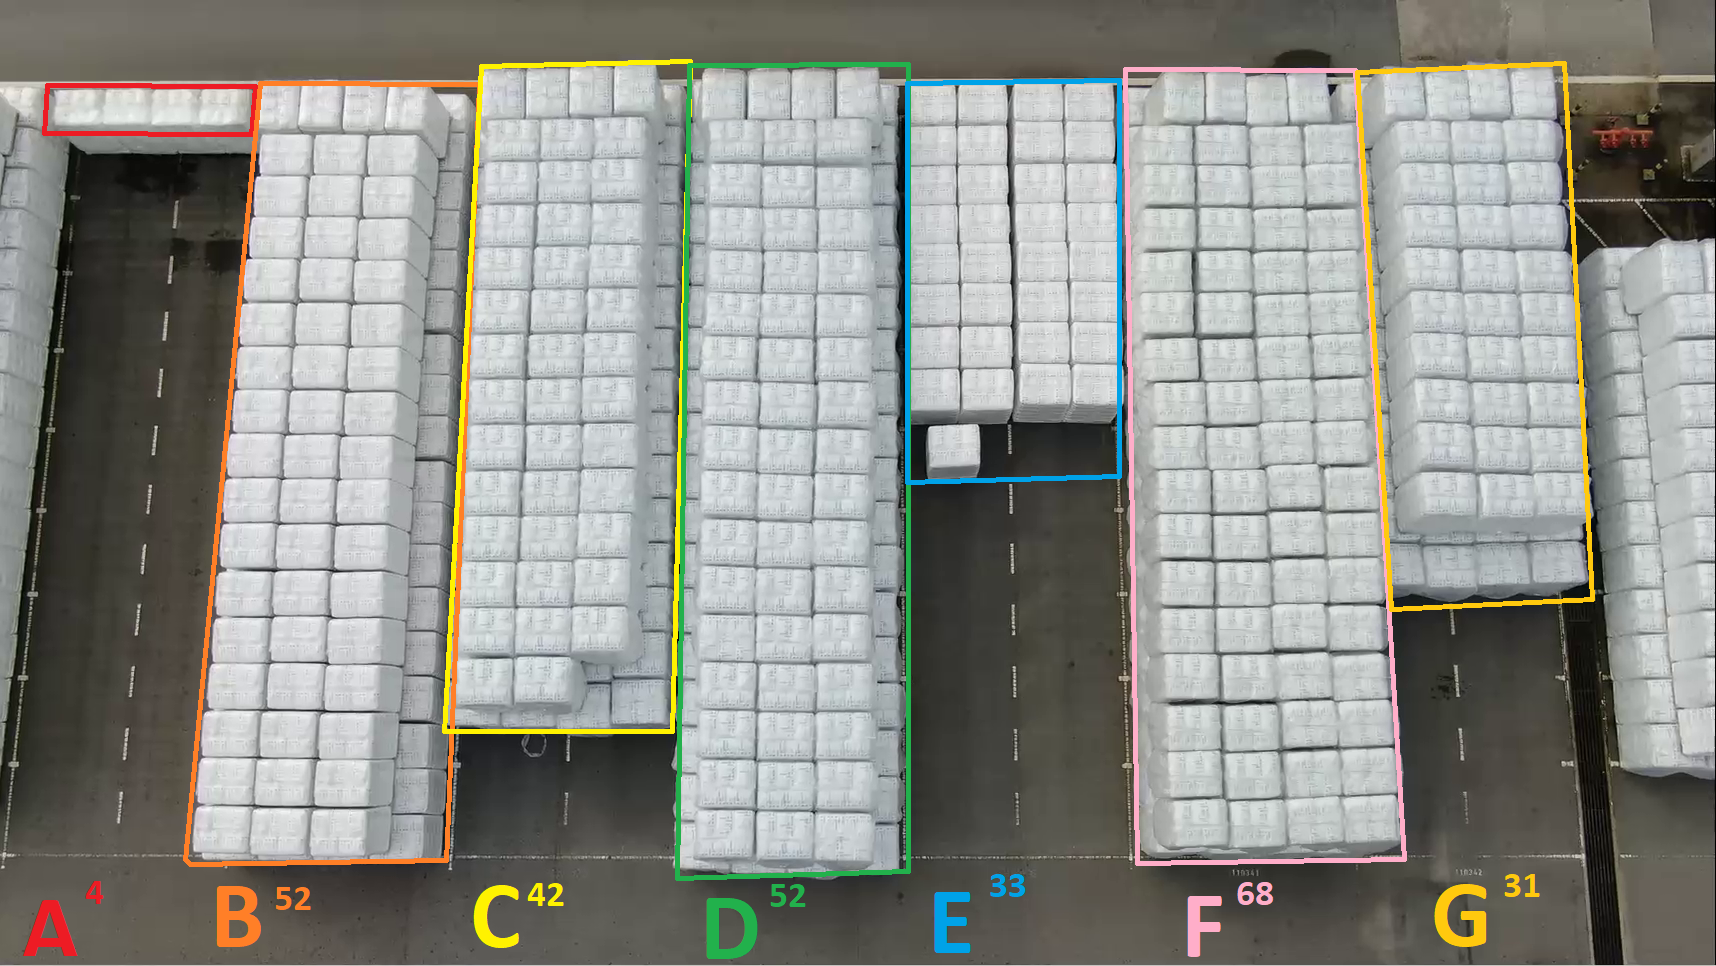


**Approach 1**:

Do a **color classification**, i.e. distinguish between warehouse floor vs boxes, estimate the area of floor covered by the boxes assuming the average size of each box. This method works for this image as the boxes look to be very similar in size and in how they are laid out. For more advanced usage, to handle lots of different scenarios like lighting, height of drone, camera intrinsics, etc, a model can be trained to perform **segment** the area occupied by boxes in each image. After segmentation, using the ratio of predicted foreground (object) area to background area, we can accurately estimate the total visible boxes by assuming the average size of visible boxes.

**Approach 2**:

Train an **object detector**. The object detector will be trained on identifying individual boxes from each image, which can be used to handle counting. Techniques like zero-shot detection can be used to improve the object detector performance on unseen objects. 


### **I will demonstrate the first approach here.**

## Loading and Analzing the Image

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

(966, 1716, 3)


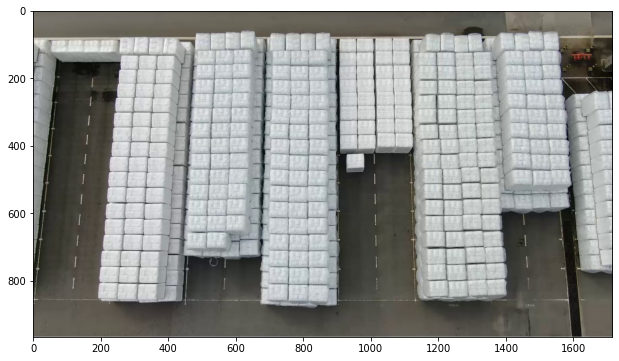

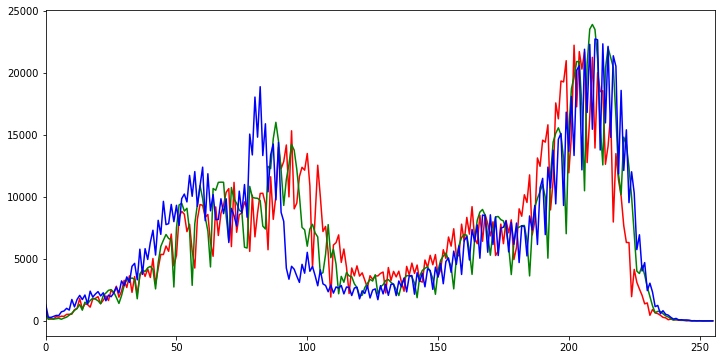

In [ ]:
im = cv2.cvtColor(cv2.imread('box_counting.png'), cv2.COLOR_BGR2RGB)
print(im.shape)
plt.figure(figsize=(12, 6))
plt.imshow(im)
plt.show()

plt.figure(figsize=(12, 6))
color = ('r','g','b')
for i,col in enumerate(color):
    histr = cv2.calcHist([im],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

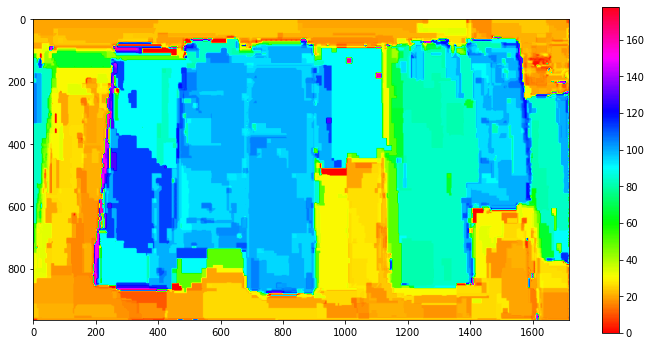

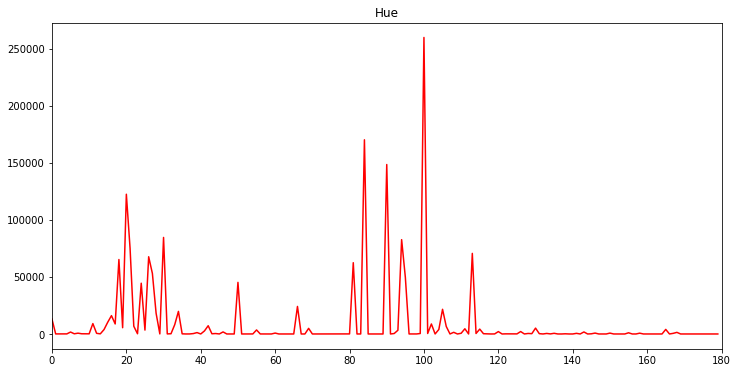

In [ ]:
im2 = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
plt.figure(figsize=(12, 6))
plt.imshow(im2[..., 0], cmap='hsv')
plt.colorbar()
plt.show()

plt.figure('hue', figsize=(12, 6))
plt.title('Hue')
histr = cv2.calcHist([im2[..., 0]],[0],None,[180],[0,180])
plt.plot(histr,color = 'r')
plt.xlim([0,180])
plt.show()

From the above Hue map and histogram, we can see that the image mainly consists of two features, centered around hue ~ 20 +- 15  which is most of the visible floor, and centered around hue ~ 100 +- 20  

## Segmenting the Image with Binarization.

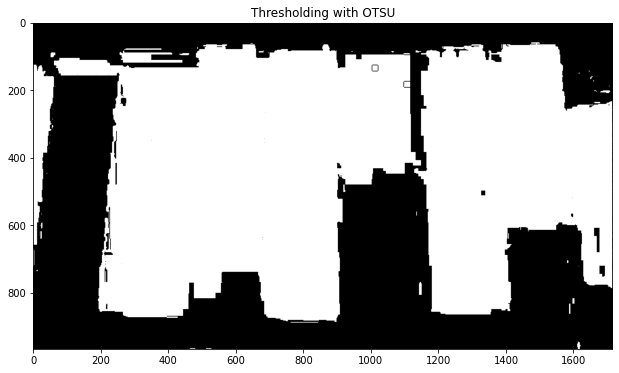

In [ ]:
tv, bin_h = cv2.threshold(im2[..., 0].copy(), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.figure(figsize=(12, 6))
plt.title('Thresholding with OTSU')
plt.imshow(bin_h, cmap='gray')
plt.show()

In [ ]:
total_fg = np.count_nonzero(bin_h)
print('Area of boxes detected:', total_fg)
print('Total Image Area:', np.prod(bin_h.shape))
print('% area occupied by boxes:', total_fg*100/np.prod(bin_h.shape))

Area of boxes detected: 954715
Total Image Area: 1657656
% area occupied by boxes: 57.59427770297336


To estimate the number of boxes, I am taking a sample from the center of image. With box starting at (237,306) with width & height of 1361, 108 respectively, I measured the number of boxes in this area to be 41.5.  

In [ ]:
# Mean area occupied by a box
total_area_sampled = 1361*108
counted_boxes = 41.5
mean_area_per_box = total_area_sampled/counted_boxes
print(f'Mean area per box {mean_area_per_box:0.2f}')


Mean area per box 3541.88


Randomly sampling 2 boxes from each lane, the median box area is ~3000. 

In [23]:
print('Estimated Boxes in the visible image (box density):', total_fg/mean_area_per_box)
print('Estimated Boxes in the visible image (random sampling):', total_fg/3000)
print('Manually counting the available boxes in lanes A-G:', 282)

Estimated Boxes in the visible image (box density): 269.5503884670857
Estimated Boxes in the visible image (random sampling): 318.23833333333334
Manually counting the available boxes in lanes A-G: 282
